# Exploring COVID-19 Cases in the US
#### Author: Victor Cannestro

### Imports

In [1]:
import numpy as np
import pandas as pd

import geopandas
from shapely.geometry import Point

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

from bokeh.layouts import column, row
from bokeh.models import Select, Panel, Tabs, Range1d, LinearAxis
from bokeh.plotting import figure, ColumnDataSource
from bokeh.io import show, output_notebook, output_file

import seaborn as sns
sns.set(font_scale=1.5) 

# Handle date time conversions between pandas and matplotlib
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from bs4 import BeautifulSoup
import requests

# Code to center plots in the screen
from IPython.core.display import HTML 
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

output_notebook()

Loading BokehJS ...

### Imports for Helper Functions

In [2]:
from helper_functions import dailyChanges
from helper_functions import smoother
from helper_functions import sumByDate

### Exploring the Time-Series

First, we import the county level time-series data gathered by the NY Times on Github (without downloading it) using `pd.read_csv()` and parse the retrieved data into an organized, multi-indexed `DataFrame`. The resulting DataFrame will be indexed by `state`, `county`, and `date` and have three columns: `fips`, `cases`, and `deaths`. Here, `fips` stands for the __F__ederal __I__nformation __P__rocessing __S__eries which are the codes most commonly used by the US Census Bureau. To download the data directly into the current working directory, instead, one could call 

```python
import urllib

url = "https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv"
filename = 'myfilename.csv'
urllib.request.urlretrieve(url, filename)
```

#### Pandas reminders:
[read_csv()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html), [DataFrame()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html), [MultiIndex](https://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html), [concat()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.concat.html#pandas.concat)

In [3]:
# URL to NY Times COVID-19 data
url = "https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv"

# Read the values, set the indices, parse the dates, and alphabetize
df = pd.read_csv(url, 
                 header=0, 
                 index_col=['state','county','date'], 
                 parse_dates=True).sort_index()

df.sample(5)

fips  cases  deaths
state          county                   date                              
Missouri       Oregon                   2020-11-09  29149.0    290       0
Alaska         Northwest Arctic Borough 2020-09-01   2188.0     66       0
Kentucky       Grant                    2020-05-31  21081.0     44       4
North Carolina Forsyth                  2020-09-15  37067.0   6668      91
               Craven                   2020-06-18  37049.0    283       5

Before moving on with further processing let's check to see if there are any missing or suspect values (like negative cases or deaths) in the data and correct them.

In [4]:
neg_cases = df.cases.values[df.cases.values < 0]
assert set(neg_cases) == set(), 'FAILED: there is a negative value' 

In [5]:
assert len(df[df.cases.isna()]) == 0, 'FAILED: there is a nan value' 

In [6]:
neg_deaths = df.deaths.values[df.deaths.values < 0]
assert set(neg_deaths) == set(), 'FAILED: there is a negative value' 

In [7]:
assert len(df[df.deaths.isna()]) == 0, 'FAILED: there is a nan value' 

We can immediately see how easy is is to look up state and county level information using this indexing scheme. Moreover, because the index is sorted by date (which is a collection of `datetime` objects) as well as alphabetically by state and county we can easily isolate the time-series data for each county in preparation for further analysis, genreating choropleths, etc. For example, let's peak at the latest King County, WA data:

In [8]:
king = df.loc[('Washington','King')] # See the latest data for King County
king.tail()

,fips,cases,deaths
date,,,
2020-11-11,53033.0,31967,848
2020-11-12,53033.0,32589,857
2020-11-13,53033.0,33387,855
2020-11-14,53033.0,34014,855
2020-11-15,53033.0,34556,855


Notice how the `cases` and `deaths` columns are expressed as the running aggregate values instead of new reported cases and deaths. Let's write a function that will accept the DataFrame and columns we're interested in and compute the difference between consecutive days. The function's implementation is kept inside the module `helper_functions.py` but we'll show the code in a markdown cell for the purpose of transparency in project documentation.

```python
def dailyChanges(dataframe: pandas.core.frame.DataFrame, cols: List[str]) -> pandas.core.frame.DataFrame:
    '''
    Args:  
        dataframe (pandas DataFrame): the input dataframe of cumulative updates. 
                                      Must be single indexed.
        cols (list): list of column labels
        
    Returns:       
        changes (pandas DataFrame): the quantized difference between daily values as the 
                                    number of new cases per day. The values should be non-
                                    negative integers and have the same shape as dataframe.
    
    Notes: Calculates array subtraction for each date in the Time Series 
           i.e.
    
           changes = df_today_values - df_yesterday_values
           
           This method utilizes the underlying numpy arrays so no for-loops are needed.
           The old method was based on elementwise subtraction via for-loop iteration:
           
           new  = [dataframe[cols].iloc[0]]
    
           # Loop over each date and take the differences
           for i in range(1, len(dataframe)):
               new.append(dataframe[cols].iloc[i] - dataframe[cols].iloc[i-1])
    
           # Convert new into a DataFrame the same indices as dataframe
           new_df = pd.DataFrame(data=new, index=dataframe.index)
    '''
    today = dataframe[cols]
    
    # 1xlen(cols) pad of zeros for first element
    pad = pd.DataFrame({k:0 for k in cols}, index=[dataframe.index[0]]) 

    # Drop the last row this means the DF stops at second to latest date
    yesterday = today.drop(today.index[-1]) 
    
    # Relabel the index so every value is dated one day ahead (needed for the subtraction later)
    yesterday.index = today.index[1:]

    # glue the zero pad to temp
    yesterday = pd.concat((pad, yesterday)) 

    # Element wise calculation of the daily changes (dates need to match up)
    changes = today - yesterday
    
    # Edit the column names to reflect the daily changes
    changes.columns = ['new_' + name for name in cols]
    
    return changes
```

In [9]:
daily_king = dailyChanges(df.loc[('Washington','King')], ['cases','deaths']).abs()
daily_king.tail()

,new_cases,new_deaths
date,,
2020-11-11,372,0
2020-11-12,622,9
2020-11-13,798,2
2020-11-14,627,0
2020-11-15,542,0


The summary statistics of these daily change columns provide us with some broad insights about how King County is being affected:
  
- `max` 
   - The most reported new cases $\approx 269$
   - The most reported new deaths $\approx 19$
   
- $\dots$

In [10]:
daily_king.describe()

,new_cases,new_deaths
count,262.000000,262.000000
mean,132.167939,3.431298
std,108.097207,3.644270
min,0.000000,0.000000
25%,64.250000,1.000000
50%,113.500000,2.000000
75%,164.000000,5.000000
max,798.000000,19.000000


To smooth out any extreme changes we'll also implement a rolling $N$-day average function using the built-in solution offered by `pandas`: [`DataFrame.rolling()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rolling.html) The function's implementation is kept inside the module `helper_functions.py` but we'll show the code in a markdown cell for the purpose of transparency in project documentation.

```python
def smoother(dataframe: pandas.core.frame.DataFrame, cols: List[str], N: int = 7) -> pandas.core.frame.DataFrame:
    '''
    Args:  
    
        dataframe (pandas DataFrame): the input dataframe of cumulative updates
        cols (list): column labels
        N (int >= 0): number of days to average
        
    Returns: 
    
        new (pandas DataFrame): smoothed N-day rolling average where the first N
                                entries are the same as dataframe. Columns are
                                renamed with 'average_' appending to beginning.
    
    Notes:
    
        The old method used for-loop iteration and a generator expression
        for readibility and to save memory but wasn't a great implementation:
        https://www.python.org/dev/peps/pep-0289/
        
        new  = []  
        # Loop over each date and take the differences
        for i in range(N, len(dataframe)):       
            # Generator expression to compute the sum
            ave = sum(dataframe[cols].iloc[i-k] for k in [*range(N)]) / N
            new.append(ave)
            
        # Get the indices of the data after the initial N-days and make DataFrame
        idx = dataframe.index[N: len(dataframe)]
        calc = pd.DataFrame(data=new, index=idx)
        
        # Append the averaged data to the initial N-days
        temp = dataframe[cols].iloc[:N].append(calc)
    '''
    # Calculate the rolling N-day average
    calc = dataframe.rolling(N).mean()
    
    # Append the averaged data to the initial N-days
    average = dataframe[cols].iloc[:N].append(calc.iloc[N:])
    
    # Edit the column name(s) in temp to include 'average'
    average.columns = ['average_' + name for name in cols]
    
    return average
```

Excellent, now we can use the information within `king` to make a variety of graphs ([bar](https://matplotlib.org/3.3.0/api/_as_gen/matplotlib.pyplot.bar.html), [step](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.step.html), [etc](https://matplotlib.org/3.1.0/gallery/color/named_colors.html).) to better understand the dynamics of the virus over time and spot any trends that may appear. To make the [dates on the x-axis look more appealing](https://www.earthdatascience.org/courses/use-data-open-source-python/use-time-series-data-in-python/date-time-types-in-pandas-python/customize-dates-matplotlib-plots-python/) we will use the `DateFormatter` module from `matplotlib` to customize the display format: `"%X %X"` where each `%X`  represents:

Syntax | Meaning | Example: (July 2020)
---|---|---
`%Y` | 4 digit year | 2020
`%y` | 2 digit year | 20
`%m` | month as a number | 07
`%b` | month as abbreviated name | Jul


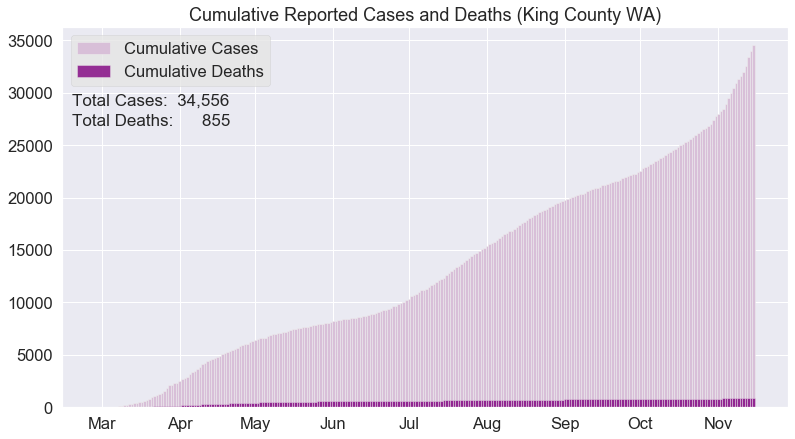

In [11]:
fig, ax = plt.subplots(figsize=(13,7))

plt.style.use('ggplot')

ax.bar(king.index,
       king.cases,
       color='thistle',
       label='Cumulative Cases',
       width=1)

ax.bar(king.index,
       king.deaths,
       color='purple',
       label='Cumulative Deaths',
       width=1,
       alpha=0.8)

ax.set_title('Cumulative Reported Cases and Deaths (King County WA)', fontsize=18)

# Annotate with the total number of cases and deaths.
ax.annotate('Total Cases:  {:,}'.format(king.cases.values[-1]), (10,302), fontsize=17, xycoords='axes pixels')
ax.annotate('Total Deaths:      {:,}'.format(king.deaths.values[-1]), (10,282), fontsize=17, xycoords='axes pixels')

date_form = DateFormatter("%b")
ax.xaxis.set_major_formatter(date_form)

plt.legend()
plt.savefig('../figures/Cumulative_King_County')
plt.show()

A close inspection of the cumulative cases and deaths plot reveals a slight inconsistency: near May there is an entry that is **less** than the day prior, which should be impossible in this type of plot. The reasoning is that it doesn't make sense to report a negative number of confirmed cases. According to the NYTs methodology:

    "In some cases, the number of cases or deaths for a state or county will decline. This can occur when a state or county corrects an error in the number of cases or deaths they've reported in the past, or when a state moves cases from one county to another. When we are able, we will historically revise counts for all impacted dates. In other cases, this will be reflected in a single-day drop in the number of cases or deaths."
    
We may remedy the situation by taking the absolute value. Henceforth, it will be a good idea to keep in mind that this data is likely an approximation. To make this more tangible, here is a result from an earlier version of this notebook: 
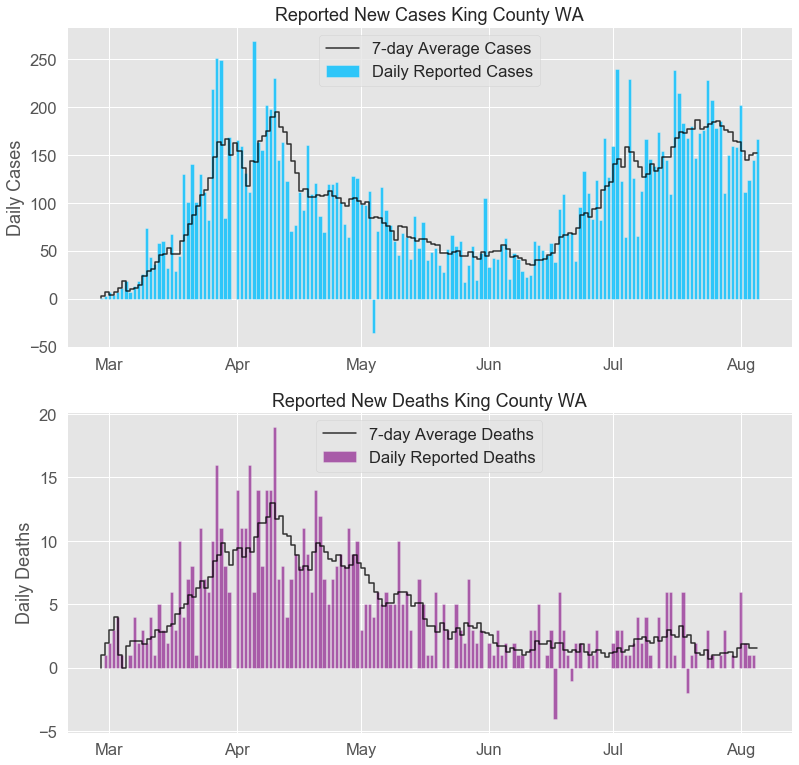

In [12]:
daily_king = dailyChanges(df.loc[('Washington','King')], ['cases','deaths']).abs()
smoothed = smoother(daily_king, daily_king.columns, 7)

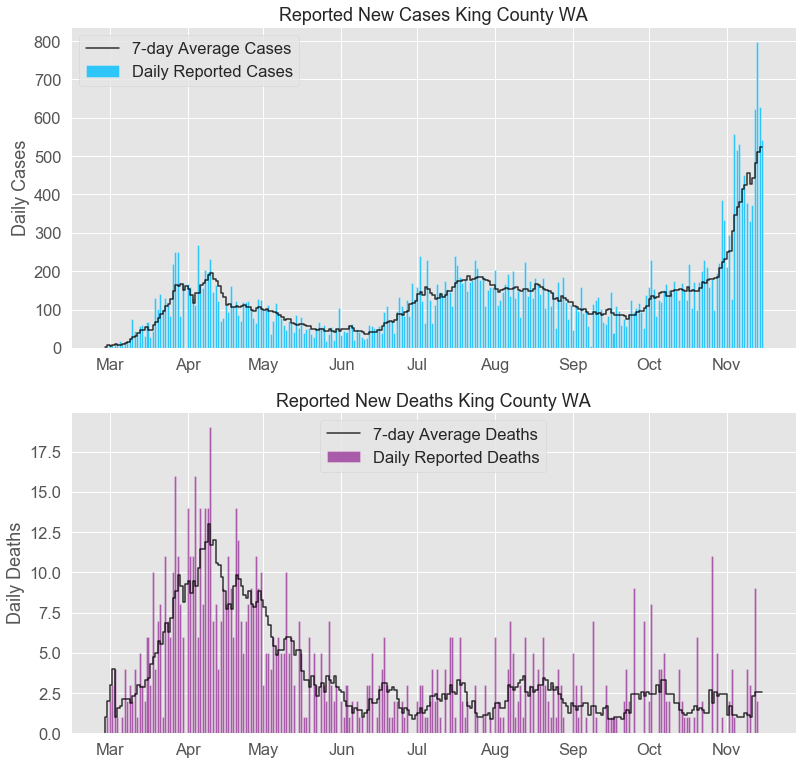

In [13]:
fig, ax = plt.subplots(2, 1, figsize=(13,13))

plt.style.use('ggplot')

# Plot the new reported cases
ax[0].bar(daily_king.index, 
           daily_king.new_cases,  
           color='deepskyblue',
           label='Daily Reported Cases',
           alpha=0.8)

ax[0].step(smoothed.index, 
           smoothed.average_new_cases, 
           color='black',
           alpha=0.8,
           label='7-day Average Cases')

# Plot the new reported deaths
ax[1].bar(daily_king.index, 
           daily_king.new_deaths, 
           color='purple',
           label='Daily Reported Deaths',
           alpha=0.6)

ax[1].step(smoothed.index, 
           smoothed.average_new_deaths, 
           color='black',
           alpha=0.8,
           label='7-day Average Deaths')

# Set axis labels and titles
ax[0].set_title('Reported New Cases King County WA', fontsize=18)
ax[0].set_ylabel('Daily Cases', fontsize=18)
ax[1].set_title('Reported New Deaths King County WA', fontsize=18)
ax[1].set_ylabel('Daily Deaths', fontsize=18)

# Format the dates displayed on the xaxis
date_form = DateFormatter("%b")
ax[0].xaxis.set_major_formatter(date_form)
ax[1].xaxis.set_major_formatter(date_form)

# Show the legend and plots
ax[0].legend()
ax[1].legend(loc='upper center')

plt.savefig('../figures/Daily_King_County')
plt.show()

### COVID-19 by US Regions

Now we'll filter `df` by regions of the US, however, it's somewhat tedious to keep this record using the full state names. As such, we'll manually add the appropriate postal code labels to a list. Next, we'll grab a mapping of the postal codes and state names from a table made available by the [Natural Resources Conservation Service (NRCS)](https://www.nrcs.usda.gov/wps/portal/nrcs/detail/?cid=nrcs143_013696) using [`BeautifulSoup`](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) and the `requests` module. Finally, we'll [merge](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html) the postal codes to `df`. Note that the `fips` columns in the two DataFrames differ. The `fips` codes given by the NRCS are directly compatible with the `.geojson` file we'll be using to make the maps.

In [14]:
# Lists of the regions of the US
northeast = ['CT', 'DE', 'ME', 'MD', 'MA', 'NH', 'NJ', 'NY', 'PA', 'RI', 'VT']
midwest = ['IL', 'IN', 'IA', 'KS', 'MI', 'MO', 'MN', 'NE', 'ND', 'OH', 'SD', 'WI']
south = ['AL', 'AR', 'FL', 'GA', 'KY', 'LA', 'MS', 'NC', 'OK', 'SC', 'TN', 'TX', 'VA', 'WV']
west = ['AK', 'AZ', 'CA', 'CO', 'HI', 'ID', 'MT', 'NV', 'NM', 'OR', 'UT', 'WA', 'WY']
mainland = set(northeast + midwest + west + south) - set(['AK', 'HI'])

# Sanity check
print(len(mainland))

48


In [15]:
url = "https://www.nrcs.usda.gov/wps/portal/nrcs/detail/?cid=nrcs143_013696"
html_content = requests.get(url).text      # Make a GET request to fetch the raw HTML content
soup = BeautifulSoup(html_content, "lxml") # Parse the html content

fips, countyName, stateName = [], [], []
for tr in soup.find_all('tr')[29:-6]: #Found bounds manually
    tds = tr.find_all('td')
    fips.append(tds[0].text.replace('\r\n\t\t\t\t',''))
    countyName.append(tds[1].text.replace('\r\n\t\t\t\t',''))
    stateName.append(tds[2].text.replace('\r\n\t\t\t\t',''))

statefips = pd.DataFrame()
statefips['name'] = fips
statefips['postal code'] = countyName
statefips['fips'] = stateName
statefips.head()

,name,postal code,fips
0,Alabama,AL,01
1,Alaska,AK,02
2,Arizona,AZ,04
3,Arkansas,AR,05
4,California,CA,06


In [16]:
# Reset the index to default
data = df.reset_index()

# Drop the old fips column and merge with the statefips DataFrame on most similar column
data = data.drop('fips', axis=1).merge(statefips, left_on='state', right_on='name', how='inner')

# Drop the redundant name and state columns and index by date
data = data.drop(['name','state'], axis=1).set_index('date').sort_values('date')
data.head()

,county,cases,deaths,postal code,fips
date,,,,,
2020-01-21,Snohomish,1,0,WA,53
2020-01-22,Snohomish,1,0,WA,53
2020-01-23,Snohomish,1,0,WA,53
2020-01-24,Cook,1,0,IL,17
2020-01-24,Snohomish,1,0,WA,53


Now we're ready to subset `data` by regions. Notice that `data`, and therefore `NE`, `S`, `MW`, `W`, have multiple entries for any single date simply because the virus spread to multiple locations as time went on. We'll need to aggregate those entries into a single instance of that date describing the number of cases for the entire region on that day before passing it to `dailyChanges()`. The function's implementation is kept inside the module `helper_functions.py` but we'll show the code in a markdown cell for the purpose of transparency in project documentation.

```python
def sumByDate(dataframe: pd.DataFrame, cols: List[str]) -> pd.DataFrame:
    '''
    Args:
        dataframe (DataFrame): A dataframe with multiple entries for 
                               any single date. Must be indexed by date.
        cols (list): list of columns to consider
        
    Returns:
        aggDF (DataFrame): A dataframe with a single entry for any
                           single date, aggregated by sum
        
    Notes:
    '''
    # Get the unique dates
    idx = dataframe.index.unique()
    sumDF = pd.DataFrame(index=idx, columns=cols)
    for date in idx:
        # aggregate by sum on a single date
        sumDF.loc[date] = dataframe[cols].loc[date].sum()
    
    return sumDf
```

In [17]:
NE = data[data['postal code'].isin(northeast)]
S = data.loc[data['postal code'].isin(south)]
MW  = data.loc[data['postal code'].isin(midwest)]
W = data.loc[data['postal code'].isin(west)]

In [18]:
# Aggregate the multiple cases on any one date
sum_NE = sumByDate(NE, ['cases','deaths'])
sum_S = sumByDate(S, ['cases','deaths'])
sum_MW = sumByDate(MW, ['cases','deaths'])
sum_W = sumByDate(W, ['cases','deaths'])

In [19]:
# Find the newly reported daily cases 
dailyNE = dailyChanges(sum_NE, ['cases','deaths'])
dailyS = dailyChanges(sum_S, ['cases','deaths'])
dailyMW = dailyChanges(sum_MW, ['cases','deaths'])
dailyW = dailyChanges(sum_W, ['cases','deaths'])

Finally, we have what's needed to produce plots of the regions. We'll also add an [annotation](https://matplotlib.org/3.3.0/api/_as_gen/matplotlib.pyplot.annotate.html) describing the percentage of the regional population that's been reported as infected with COVID-19 using regional population data from the  [US Census Bureau](https://www.census.gov/popclock/print.php?component=growth&image=//www.census.gov/popclock/share/images/growth_1561939200.png). 

In [20]:
# Populations as of the 2019 Census
popNE, popS, popMW, popW = 55982803, 68329004, 78347268, 125580448

# Number of total cases per region 
casesW, casesMW, casesNE, casesS = dailyW.sum()[0], dailyMW.sum()[0], dailyNE.sum()[0], dailyS.sum()[0]

# Number of total deaths per region 
deathsW, deathsMW, deathsNE, deathsS = dailyW.sum()[1], dailyMW.sum()[1], dailyNE.sum()[1], dailyS.sum()[1]

# Percent of regional population infected
percentW = (casesW / popW) * 100
percentMW = (casesMW / popMW) * 100
percentNE = (casesNE / popNE) * 100
percentS = (casesS / popS) * 100

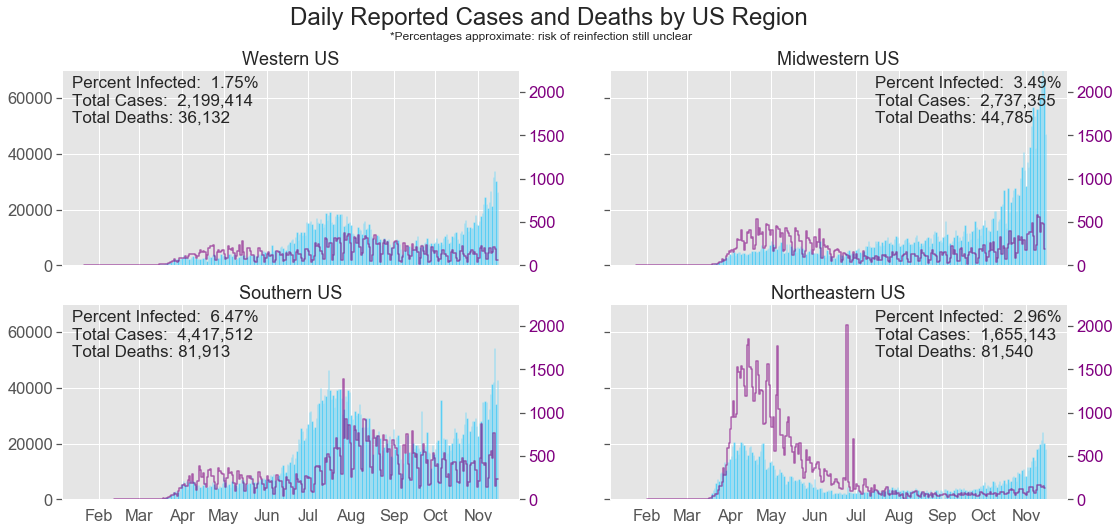

In [41]:
fig, ax = plt.subplots(2,2, sharey=True, sharex=True, figsize=(18,8))

plt.style.use('ggplot')

# Format the dates displayed on the xaxis
date_form = DateFormatter("%b")

# Set overall title
fig.suptitle('Daily Reported Cases and Deaths by US Region', fontsize=24)

# Pad the space on the top to allow for an annotation below suptitle
fig.subplots_adjust(top=0.87)
plt.annotate('*Percentages approximate: risk of reinfection still unclear', (-220,460), 
                  fontsize=12, 
                  xycoords='axes pixels')

# Tuples of Cases, deaths, and percentages of population for later annotations
numbers = [(percentW, int(casesW), int(deathsW)),
           (percentMW, int(casesMW), int(deathsMW)),
           (percentNE, int(casesNE), int(deathsNE)),
           (percentS, int(casesS), int(deathsS))]

plot_data = [dailyW, dailyMW, dailyNE, dailyS]

titles = ['Western US', 'Midwestern US', 'Northeastern US', 'Southern US']

# Will effectively become [axW, axMW, axNE, axS]
new_axes = []
axes = [ax[0,0], ax[0,1], ax[1,1], ax[1,0]]

# Set the cases plot parameters in a relatively efficient manner
for i, axis in enumerate(axes):
    # Set titles
    axis.set_title(titles[i], fontsize=18)
    
    # Format the dates displayed on the xaxis
    axis.xaxis.set_major_formatter(date_form)
    
    # Annotate with the total number of cases and deaths.
    axis.annotate('Percent Infected:  {:.2f}%\nTotal Cases:  {:,}\nTotal Deaths: {:,}'.format(*numbers[i]), 
                  (10,143) if axis not in [ax[0,1], ax[1,1]] else (265,143), 
                  fontsize=17, 
                  xycoords='axes pixels')
    
    # Plot cases bar graph
    axis.bar(plot_data[i].index, 
             plot_data[i].new_cases, 
             width=1,
             color='deepskyblue',
             alpha=0.6)
    
    axis.set_ylim([0,70000])
    
    # Make dual axes
    new_axes.append(axis.twinx())

# Set the deaths plot parameters in a relatively efficient manner
for i, axis in enumerate(new_axes):
    # Make the tick labels the color of the deaths graphs
    axis.tick_params(axis='y', labelcolor='purple')
    
    # Modify the dual axes xlabels
    axis.xaxis.set_major_formatter(date_form)
    
    # Manually limit the y axis bounds
    axis.set_ylim([0,2250])
    
    # Turn off second grid
    axis.grid(False)
    
    # Plot deaths
    new_axes[i].step(plot_data[i].index, 
                     plot_data[i].new_deaths,  
                     color='purple',
                     alpha=0.6)
    
plt.savefig('../figures/Daily_US_Regions')
plt.show()

Now let's view this with a different plotting library, **Bokeh**. Bokeh allows us to write simpler code and produce [better looking](https://docs.bokeh.org/en/latest/docs/user_guide/styling.html), interactive visualizations. Below we'll make a tabbed visualization of COVID-19 cases by US region. 

In [22]:
ps = []
tabs = []
for i, p in enumerate(plot_data):
    p = figure(x_axis_type='datetime', 
               x_axis_label='Date', 
               y_axis_label='Daily Changes Weekly',
               y_range=(0, 70000),
               title='COVID-19 Cases and Deaths',
               plot_width=900, plot_height=400)
    
    # Set background style
    p.background_fill_color = "lightgray"
    p.background_fill_alpha = 0.2
    p.xgrid.grid_line_color = 'white'
    p.ygrid.grid_line_color = 'white'

    # Setting the second y axis range name and range
    p.extra_y_ranges = {"New deaths": Range1d(start=0, end=2250)}
    
    # Adding the second axis to the plot.  
    p.add_layout(LinearAxis(y_range_name="New deaths"), 'right')
    
    # Add cases to plot
    p.line(plot_data[i].index, 
           plot_data[i].new_cases, 
           color='deepskyblue', 
           legend_label='New cases')
    
    # Add deaths to plot
    p.line(plot_data[i].index, 
           plot_data[i].new_deaths, 
           color='purple', 
           y_range_name='New deaths', 
           legend_label='New deaths')
    
    # Format the legend
    p.legend.location = 'top_left'
    p.legend.background_fill_color = "gray"
    p.legend.background_fill_alpha = 0.1
    
    # Add p and tabs to appropriate lists
    ps.append(p)
    tabs.append(Panel(child=p, title=titles[i]))

tabs = Tabs(tabs=tabs)
output_file('tabbed.html')
show(tabs)

### COVID-19 in the US as a Whole
Rather than aggregating `cases` and `deaths` by `datetime` instance to get the total daily reported cases and deaths in the US, let's import a dataset that already has that information and produce a bar graph.

In [23]:
# URL to NY Times COVID-19 data
url = "https://raw.githubusercontent.com/nytimes/covid-19-data/master/us.csv"

# Read the values, set the indices, parse the dates, and alphabetize
usa = pd.read_csv(url, 
                  header=0, 
                  index_col=['date'], 
                  parse_dates=True).sort_index()
usa.tail(3)

,cases,deaths
date,,
2020-11-13,10818614,244250
2020-11-14,10977735,245460
2020-11-15,11112922,246083


In [24]:
usa_daily = dailyChanges(usa, ['cases','deaths'])
usa_daily.tail(3)

,new_cases,new_deaths
date,,
2020-11-13,181196,1389
2020-11-14,159121,1210
2020-11-15,135187,623


In [25]:
usa_pop = 328231337 # from 2019 Census
usa_cases = usa.cases.values[-1]
usa_deaths = usa.deaths.values[-1]
percent_infected = (usa_cases / usa_pop) * 100

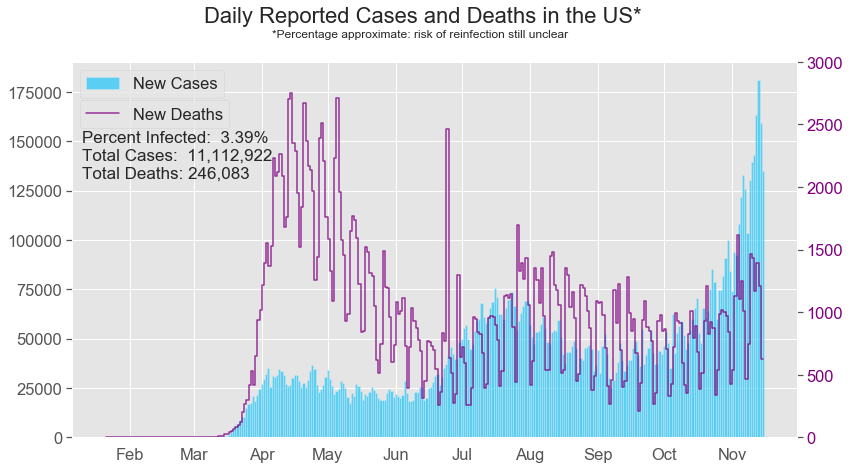

In [26]:
fig, ax = plt.subplots(figsize=(13,7))

plt.style.use('ggplot')

# Let the deaths be described by another pair of axis for enlargement
ax2 = ax.twinx()

# Plot the new US cases
ax.bar(usa_daily.index,
       usa_daily.new_cases,
       color='deepskyblue',
       label='New Cases',
       width=1,
       alpha=0.6)

# Plot the new US deaths
ax2.step(usa_daily.index,
         usa_daily.new_deaths,
         color='purple',
         label='New Deaths',
         alpha=0.8)

# Pad the space on the top to allow for an annotation below suptitle
fig.suptitle('Daily Reported Cases and Deaths in the US*', fontsize=22)
fig.subplots_adjust(top=0.87) 
plt.annotate('*Percentage approximate: risk of reinfection still unclear', (200,400), 
              fontsize=12, 
              xycoords='axes pixels')

# Annotate with the total number of cases and deaths. 
ax.annotate('Percent Infected:  {:.2f}%\nTotal Cases:  {:,}\nTotal Deaths: {:,}'.format(percent_infected, usa_cases, usa_deaths), 
            (10,260), 
            fontsize=17, 
            xycoords='axes pixels')

# Formate the x-axis dates
date_form = DateFormatter("%b")
ax.xaxis.set_major_formatter(date_form)

# Make ax2 tick labels the color of the graph
ax2.tick_params(axis='y', labelcolor='purple')
ax2.set_ylim([0,3000])

# Format the legend and grid
ax.legend(loc='upper left')
ax2.legend(loc='upper left', bbox_to_anchor=(0, 0.92))
ax2.grid(False)

# Save the figure
plt.savefig('../figures/Daily_US')
plt.show()

***
### Underlying US County and State Boundary Maps

The data was obtained through the the US Census Bereau, which provided the `.shp` files of the boudary data. An [online file conversion tool](https://mygeodata.cloud/converter/) was then used to generate `geojson` files from the raw boundary data. 

- https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html
- https://eric.clst.org/tech/usgeojson/

- https://github.com/johan/world.geo.json/tree/master/countries/USA


- [State FIPS Codes](https://www.nrcs.usda.gov/wps/portal/nrcs/detail/?cid=nrcs143_013696)
- [County FIPS Codes](https://www.nrcs.usda.gov/wps/portal/nrcs/detail/national/home/?cid=nrcs143_013697)

In [27]:
# Don't include 'Unknown' counties for the upcoming geospatial visualizations
df = df[~(df.index.get_level_values(1) == 'Unknown')]

In [28]:
# Getting to know GEOJSON file:
counties = geopandas.read_file("../data/cb_2018_us_county_20m.geojson")
print(len(counties))
print(type(counties))
counties.sort_values(by=['STATEFP','NAME']).head(3)

3220
<class 'geopandas.geodataframe.GeoDataFrame'>


,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
492,01,001,00161526,0500000US01001,01001,Autauga,06,1539602123,25706961,"POLYGON ((-86.91760 32.66417, -86.71339 32.661..."
2009,01,003,00161527,0500000US01003,01003,Baldwin,06,4117546676,1133055836,"POLYGON ((-88.02632 30.75336, -87.94455 30.827..."
2428,01,005,00161528,0500000US01005,01005,Barbour,06,2292144655,50538698,"POLYGON ((-85.73573 31.62449, -85.66565 31.786..."


In [29]:
# Merge df with the statefips DataFrame on state and name and drop redundant colum
df = df.reset_index().merge(statefips, left_on='state', right_on='name', how='inner').drop(['name','state','fips_x'], axis=1)

# Merge df with the statefips DataFrame on most similar column
data = df.merge(statefips, left_on='fips_y', right_on='fips', how='inner')

# Drop the redundant columns and index by postal code, county, date
data = data.drop(['name','fips_y','postal code_y'], axis=1).set_index(['postal code_x','county','date']).sort_values('date')
data.head()

cases  deaths fips
postal code_x county    date                          
WA            Snohomish 2020-01-21      1       0   53
                        2020-01-22      1       0   53
                        2020-01-23      1       0   53
IL            Cook      2020-01-24      1       0   17
WA            Snohomish 2020-01-24      1       0   53

In [30]:
# Merge with the statefips DataFrame on state and name and drop redundant columns
counties = statefips.merge(counties, left_on='fips', right_on='STATEFP', how='inner').drop(['name', 'fips'], axis=1)

# Check dimensions and type
print(len(counties))
print(type(counties))

# Convert DataFrame to GeoDataFrame for geospatial plotting
counties = geopandas.GeoDataFrame(counties)
counties.sort_values(by=['STATEFP','NAME']).head(3)

3219
<class 'pandas.core.frame.DataFrame'>


,postal code,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
12,AL,01,001,00161526,0500000US01001,01001,Autauga,06,1539602123,25706961,"POLYGON ((-86.91760 32.66417, -86.71339 32.661..."
42,AL,01,003,00161527,0500000US01003,01003,Baldwin,06,4117546676,1133055836,"POLYGON ((-88.02632 30.75336, -87.94455 30.827..."
50,AL,01,005,00161528,0500000US01005,01005,Barbour,06,2292144655,50538698,"POLYGON ((-85.73573 31.62449, -85.66565 31.786..."


In [31]:
find_counties = counties.set_index(['postal code','NAME'])
find_counties.head()

STATEFP COUNTYFP  COUNTYNS        AFFGEOID  GEOID LSAD  \
postal code NAME                                                              
AL          Cullman       01      043  00161547  0500000US01043  01043   06   
            Franklin      01      059  00161555  0500000US01059  01059   06   
            Choctaw       01      023  00161537  0500000US01023  01023   06   
            Pike          01      109  00161581  0500000US01109  01109   06   
            Lamar         01      075  00161563  0500000US01075  01075   06   

                           ALAND    AWATER  \
postal code NAME                             
AL          Cullman   1903073019  52422496   
            Franklin  1641841406  32643981   
            Choctaw   2365869835  19144469   
            Pike      1740647518   2336975   
            Lamar     1566544637   1600679   

                                                               geometry  
postal code NAME                                                         
AL          Cullman   POLYGON ((-87.11199 33.99238, -87.10991 34.299...  
            Franklin  POLYGON ((-88.15490 34.46303, -88.13956 34.581...  
            Choctaw   POLYGON ((-88.46866 31.89386, -88.46866 31.933...  
            Pike      POLYGON ((-86.19138 31.96645, -85.99556 31.967...  
            Lamar     POLYGON ((-88.25445 33.69878, -88.24839 33.744...

## Action Item

    "Many state health departments choose to report cases separately when the patient’s county of residence is unknown or pending determination. In these instances, we record the county name as “Unknown.” As more information about these cases becomes available, the cumulative number of cases in “Unknown” counties may fluctuate."
    


In [32]:
to_drop = []

for state in mainland:
    # all the counties in the covid 19 data
    data_set = set(data.loc[state].index.get_level_values(0).unique())
    
    # all the counties in the shapefile data
    counties_set = set(find_counties.index.get_level_values(1))
    difference = data_set - counties_set
    
    # collect all 'counties' to drop
    if len(difference) > 0:
        print(state)
        print(difference, '\n')
        to_drop.append(list(difference))

VA
{'Newport News city', 'Hampton city', 'Williamsburg city', 'Martinsville city', 'Portsmouth city', 'Petersburg city', 'Hopewell city', 'Alexandria city', 'Waynesboro city', 'Fredericksburg city', 'Lexington city', 'Bristol city', 'Fairfax city', 'Norton city', 'Poquoson city', 'Salem city', 'Winchester city', 'Covington city', 'Radford city', 'Emporia city', 'Manassas Park city', 'Chesapeake city', 'Norfolk city', 'Staunton city', 'Danville city', 'Manassas city', 'Colonial Heights city', 'Buena Vista city', 'Franklin city', 'Harrisonburg city', 'Galax city', 'Charlottesville city', 'Richmond city', 'Virginia Beach city', 'Lynchburg city', 'Falls Church city', 'Roanoke city', 'Suffolk city'} 

MO
{'Kansas City', 'Joplin', 'St. Louis city'} 

NY
{'New York City'} 

MD
{'Baltimore city'} 



In [33]:
# Clunky way to filter out 'Counties' not in shapefile
for i in range(len(to_drop)):
    for j in range(len(to_drop[i])):
        data = data[~(data.index.get_level_values(1) == to_drop[i][j])]
data

cases  deaths fips
postal code_x county    date                          
WA            Snohomish 2020-01-21      1       0   53
                        2020-01-22      1       0   53
                        2020-01-23      1       0   53
IL            Cook      2020-01-24      1       0   17
WA            Snohomish 2020-01-24      1       0   53
...                                   ...     ...  ...
TX            Freestone 2020-11-15    486       8   48
NC            Mitchell  2020-11-15    402       4   37
OH            Seneca    2020-11-15   1275      15   39
NC            Moore     2020-11-15   2556      58   37
WY            Weston    2020-11-15    339       0   56

[718950 rows x 3 columns]

In [34]:
data = data.reset_index()
find_counties = find_counties.reset_index()

In [35]:
data[data.date == '2020-04-21']

,postal code_x,county,date,cases,deaths,fips
73682,OK,Latimer,2020-04-21,4,1,40
73683,MN,Scott,2020-04-21,27,1,27
73684,KS,Scott,2020-04-21,1,0,20
73685,IA,Dickinson,2020-04-21,2,0,19
73686,ID,Bingham,2020-04-21,3,0,16
...,...,...,...,...,...,...
76394,OK,Harper,2020-04-21,1,0,40
76395,GA,Spalding,2020-04-21,136,8,13
76396,NC,Duplin,2020-04-21,32,0,37
76397,PA,Cambria,2020-04-21,20,2,42


In [36]:
combined = find_counties.merge(right=data, right_on=['postal code_x','county'], left_on=['postal code','NAME'])
combined = combined.drop(['postal code_x','NAME','fips'], axis=1)
combined.head()

,postal code,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,LSAD,ALAND,AWATER,geometry,county,date,cases,deaths
0,AL,01,043,00161547,0500000US01043,01043,06,1903073019,52422496,"POLYGON ((-87.11199 33.99238, -87.10991 34.299...",Cullman,2020-03-20,1,0
1,AL,01,043,00161547,0500000US01043,01043,06,1903073019,52422496,"POLYGON ((-87.11199 33.99238, -87.10991 34.299...",Cullman,2020-03-21,2,0
2,AL,01,043,00161547,0500000US01043,01043,06,1903073019,52422496,"POLYGON ((-87.11199 33.99238, -87.10991 34.299...",Cullman,2020-03-22,2,0
3,AL,01,043,00161547,0500000US01043,01043,06,1903073019,52422496,"POLYGON ((-87.11199 33.99238, -87.10991 34.299...",Cullman,2020-03-23,2,0
4,AL,01,043,00161547,0500000US01043,01043,06,1903073019,52422496,"POLYGON ((-87.11199 33.99238, -87.10991 34.299...",Cullman,2020-03-24,3,0


### Making the Choropleths

"When making choropleths, it is important to always use a variable that is normalized for the area being plotted. Further, by using a classification scheme instead of a continuous color scale, we can make the map more easily interpretable."

To make the [choropleth map](https://geopandas.readthedocs.io/en/latest/mapping.html) I’ll need to do something like:

`covid19_county_data.plot(column=’cases’, scheme=quantile, k=12, cmap=’Purples’)`

- The color scheme is a graduated sequential scheme
    - I.e. `categorical=False`


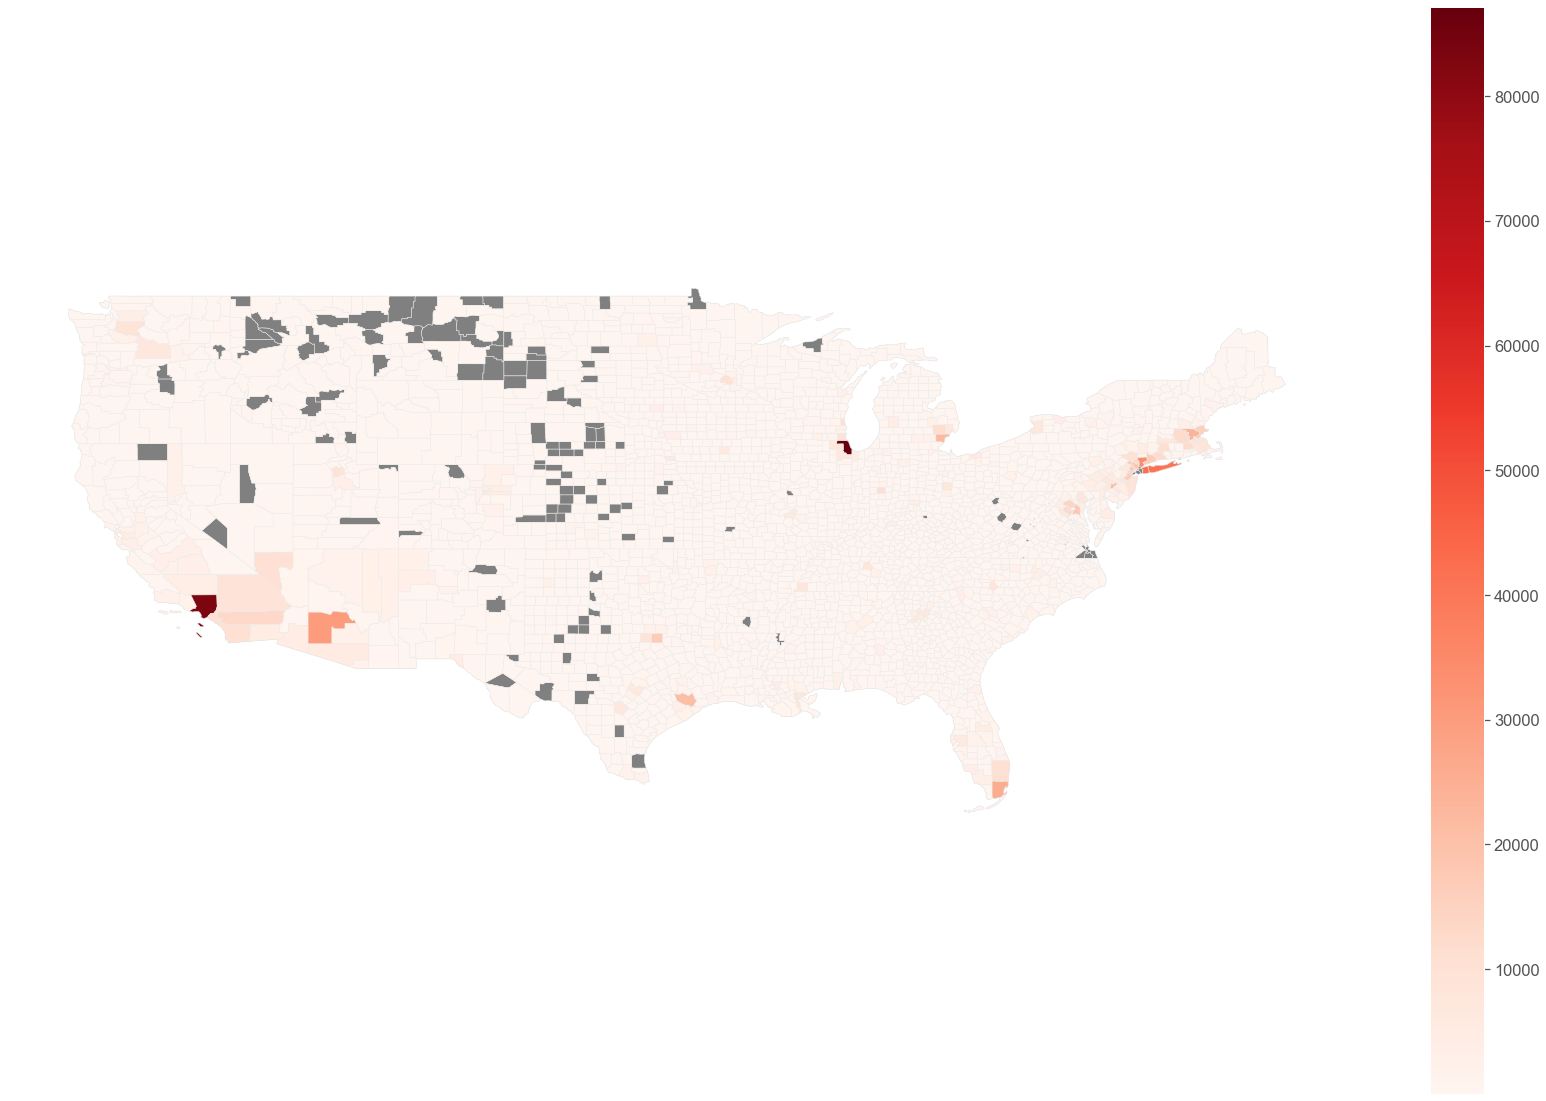

In [37]:
# Mainland US
mask = combined['postal code'].isin(mainland)
combined = combined[mask]

ax = find_counties[find_counties['postal code'].isin(mainland)].plot(figsize=(30,20), color='gray')
combined[combined.date == '2020-06-21'].plot(column='cases', cmap='Reds', figsize=(30,20), ax=ax, legend=True)
plt.axis('off')
plt.show()

__Action item:__ create a function that takes a geopandas DF and loops through each date and creates a choropleth based on the number of cases/100k

In [38]:
#merged = pd.merge_ordered(WA, new, how='left', on='NAME').fillna(0)
    
#merged.plot()#column='new cases', cmap='BuGn', edgecolor='black') 
    
#plt.title('New COVID-19 cases on ')
#plt.axis('off')
#plt.savefig('figs/New COVID-19 cases on '+str(d)[:10]);
#plt.show()

### Animation

To make the animations we'll employ [Holoviews](http://holoviews.org/gallery/apps/bokeh/gapminder.html#apps-bokeh-gallery-gapminder), a package built on top of Bokeh that can produce even more powerful visualizations.

- Make animation of new cases vs time


- Number of total infections vs time

In [39]:
! pytest ../tests/test_helper_functions.py

============================= test session starts =============================
platform win32 -- Python 3.7.6, pytest-5.3.5, py-1.8.1, pluggy-0.13.1
rootdir: C:\Users\victo\Dropbox\COVID-19_project
plugins: hypothesis-5.5.4, arraydiff-0.3, astropy-header-0.1.2, doctestplus-0.5.0, mypy-0.6.2, openfiles-0.4.0, remotedata-0.3.2
collected 11 items

..\tests\test_helper_functions.py ...........                            [100%]

============================= 11 passed in 0.54s ==============================
